In [3]:
import tensorflow as tf
import string,os,glob
import tensorflow.keras.callbacks
from tensorflow.keras.applications import MobileNet

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tqdm import tqdm_notebook
from tensorflow.keras.preprocessing.image import load_img
import pickle
from time import time
import numpy as np
from PIL import Image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional,Concatenate,Embedding, TimeDistributed, Dense, RepeatVector,Activation, Flatten, Reshape, concatenate, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import Input
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras import layers

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import random,copy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [5]:
base_folder = '/content/drive/Shared drives/zhaozixuan67/20FallMLfinal/Project'
data_folder = '/content/drive/Shared drives/zhaozixuan67/20FallMLfinal/Project/Data'

In [6]:
import pickle
def loadmodel(mname):
    f=open(mname,"rb")
    lookup=pickle.load(f)
    maxlength=0
    for v in lookup.values():
        for i in v:
            maxlength=max(maxlength,len(i.split(' ')))
    
    # create the unique word set
    lex = set()
    for k in lookup.keys():
        [lex.update(d.split()) for d in lookup[k]]
    return lookup,lex,maxlength

In [7]:
import tensorflow.keras.backend as K
def data_generator(descriptions, photos, wtoi, max_length, num_photos_batch_size):
    # training data for images
    # caption
    # rest of the caption
    # global yield_values
    x1,x2,y = [],[],[]
    print("in gener,lendic ",len(descriptions))

    for key,desc_list in descriptions.items():
        photo = photos[key]
        for desc in desc_list:
            # seq is sequence id
            seq = [wtoi[word] for word in desc.split() if word in wtoi]
            # add the start and end indicator
            seq.insert(0,wtoi[START])
            seq.append(wtoi[END])
            for i in range(1,len(seq)):
                in_seq, out_seq = seq[:i],seq[i]
                in_seq = pad_sequences([in_seq],maxlen=max_length)[0]
                # the out_seq is one-hot encoding
                out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                x1.append(photo)
                x2.append(in_seq)
                y.append(out_seq)

            
    print("out gener,lenx:",len(x1))
    return [[np.array(x1),np.array(x2)], np.array(y)]


            # print([[np.array(x1).shape,np.array(x2).shape], np.array(y).shape])
            # yield_values = [[np.array(x1),np.array(x2)], np.array(y)]
            # yield [[np.array(x1),np.array(x2)], np.array(y)]

In [8]:
def buildmodel(structid):
    if structid==1:
        WIDTH,HEIGHT,OUTPUT_DIM=299,299,2048
        inputs1 = Input(shape=(OUTPUT_DIM,),name="image_features") # image features
        fe1 = Dropout(0.5,name="img_dropout")(inputs1)
        fe2 = Dense(512,activation='relu',name="img_dense")(fe1)
        inputs2 = Input(shape=(max_length,),name="captions") # gradually accending caption
        se1 = Embedding(vocab_size,embedding_dim,mask_zero=True,name="glove_embedding")(inputs2)
        se2 = Dropout(0.5,name="text_dropout")(se1)
        se3 = Bidirectional(LSTM(256,name="text_LSTM"))(se2)
        decorder1 = layers.add([fe2,se3],name="merge") # 256
        decorder2 = Dense(256,activation='relu',name="merge_dense")(decorder1)
        outputs = Dense(vocab_size,activation='softmax',name="prob_distribution")(decorder2)
        caption_model = Model(inputs=[inputs1,inputs2], outputs=outputs)
    elif structid==2:
        STRUCT=2
        WIDTH,HEIGHT,OUTPUT_DIM=299,299,2048
        inputs1 = Input(shape=(OUTPUT_DIM,),name="image_features") # image features
        fe1 = Dropout(0.5,name="img_dropout")(inputs1)
        fe2 = Dense(128,activation='relu',name="img_dense")(fe1)
        inputs2 = Input(shape=(max_length,),name="captions") # gradually accending caption
        se1 = Embedding(vocab_size,embedding_dim,mask_zero=True,name="glove_embedding")(inputs2)
        se2 = Dropout(0.5,name="text_dropout")(se1)
        se3 = LSTM(128,name="text_LSTM")(se2)
        decorder1 = Concatenate()([fe2,se3])
        decorder2 = Dense(256,activation='relu',name="merge_dense")(decorder1)
        outputs = Dense(vocab_size,activation='softmax',name="prob_distribution")(decorder2)
        caption_model = Model(inputs=[inputs1,inputs2], outputs=outputs)
    elif structid==3:
        STRUCT=3
        WIDTH,HEIGHT,OUTPUT_DIM=299,299,2048
        inputs1 = Input(shape=(OUTPUT_DIM,),name="image_features") # image features
        fe1 = Dropout(0.5,name="img_dropout")(inputs1)
        fe2 = Dense(256,activation='relu',name="img_dense")(fe1)
        inputs2 = Input(shape=(max_length,),name="captions") # gradually accending caption
        se1 = Embedding(vocab_size,embedding_dim,mask_zero=True,name="glove_embedding")(inputs2)
        se2 = Dropout(0.5,name="text_dropout")(se1)
        se3 = Bidirectional(LSTM(128,name="text_LSTM"))(se2)
        decorder1 = Concatenate()([fe2,se3])
        decorder2 = Dense(256,activation='relu',name="merge_dense")(decorder1)
        outputs = Dense(vocab_size,activation='softmax',name="prob_distribution")(decorder2)
        caption_model = Model(inputs=[inputs1,inputs2], outputs=outputs)
    else:#4
        WIDTH,HEIGHT,OUTPUT_DIM=299,299,2048
        inputs1 = Input(shape=(OUTPUT_DIM,),name="image_features") # image features
        fe1 = Dropout(0.5,name="img_dropout")(inputs1)
        fe2 = Dense(128,activation='relu',name="img_dense")(fe1)
        inputs2 = Input(shape=(max_length,),name="captions") # gradually accending caption
        se1 = Embedding(vocab_size,embedding_dim,mask_zero=True,name="glove_embedding")(inputs2)
        se2 = Dropout(0.5,name="text_dropout")(se1)
        se3 = LSTM(128,name="text_LSTM",return_sequences=True)(se2)
        se4 = LSTM(128,name="text_LSTM_2")(se3)
        decorder1 = Concatenate()([fe2,se4])
        decorder2 = Dense(256,activation='relu',name="merge_dense")(decorder1)
        outputs = Dense(vocab_size,activation='softmax',name="prob_distribution")(decorder2)
        caption_model = Model(inputs=[inputs1,inputs2], outputs=outputs)
    return caption_model

In [9]:
import gc
from tensorflow import keras
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
 
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

def train_model(caption_model,batchsize,model_path,modelid,mname,EPOCHS = 10,):
    history = LossHistory()
#     checkpoint = ModelCheckpoint(model_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#     callbacks_list = [checkpoint]
    values = data_generator(train_id_to_captions,encoding_dict,word_to_id,max_length,num_pics_per_batch)
    # caption_model.fit_generator(generator,epochs=1,steps_per_epoch=steps)
    print("fitting")
    print("sizecheck: ",len(values[0][0]),len(values[0][1]),len(values[1]))
    caption_model.fit(values[0],values[1],batch_size=batchsize,epochs=EPOCHS,validation_split=0.1,verbose=1,callbacks=[history])#,callbacks=callbacks_list)
    gc.collect()
        #save after every epoch
    caption_model.save(model_path)
    with open(working_base+"/chen/chen-loss"+str(MODELID)+"-"+"1024"+"-ep"+str(EPOCHS)+".pkl",'wb') as f:
        pickle.dump(history.losses,f)
        
    print("saved")
    

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
def generateCaption(image):
    in_text = START
    for i in range(max_length):
        id_seq = [word_to_id[w] for w in in_text.split() if w in word_to_id.keys()]
        id_seq = pad_sequences([id_seq],maxlen=max_length)
        yhat = caption_model.predict([image,id_seq],verbose=0)
        yhat = np.argmax(yhat)
        word = id_to_word[yhat]
        in_text += ' ' + word
        if word == END:
            break
    output = in_text.split()
    output = output[1:-1]
    output = ' '.join(output)
    return output

In [12]:
ResNet50 = ResNet50(include_top=True,
    weights="imagenet",
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",)
encoder = Model(ResNet50.input,ResNet50.layers[-2].output)
WIDTH,HEIGHT,OUTPUT_DIM=299,299,2048
def encodeImage(img):
    from PIL import Image
    img = img.resize((HEIGHT,WIDTH),Image.ANTIALIAS)
    x = img_to_array(img)
    x = np.expand_dims(x,axis=0)
    x = preprocess_input(x)
    x = encoder.predict(x)
    x = np.reshape(x,OUTPUT_DIM)
    return x

102973440/102967424 [==============================] - 4s 0us/step


In [13]:
os.chdir('/content/drive/Shared drives/zhaozixuan67/20FallMLfinal/Project/workspace/chen')

In [14]:
import gc
import os
epoches=100
#datasets=["womanwomen-1787-dataset.pkl","manmen-3042-dataset.pkl","girl-1736-dataset.pkl","dog-2300-dataset.pkl","boy-1837-dataset.pkl"]
datasets=["sizedown-20k-dataset.pkl"]
embedding_index = {}

with open(os.path.join(f'{data_folder}/glove/glove.6B.200d.txt'),encoding='utf-8') as f:
    for line in tqdm_notebook(f.readlines()):
        vals = line.split()
        word = vals[0]
        coefs = np.array(vals[1:],dtype='float32')
        embedding_index[word] = coefs

print(f"{len(embedding_index)} word vectors")


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



400000 word vectors


---------------------------------------------train model  1  on  sizedown-20k-dataset.pkl
image pickle is loaded
31158
len of encoding dict:  20589
image pickle (test) is loaded
11006 frequent words
modelid:  1
Model: "functional_75"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
captions (InputLayer)           [(None, 45)]         0                                            
__________________________________________________________________________________________________
image_features (InputLayer)     [(None, 2048)]       0                                            
__________________________________________________________________________________________________
glove_embedding (Embedding)     (None, 45, 200)      2201800     captions[0][0]                   
_________________________________________________________________________

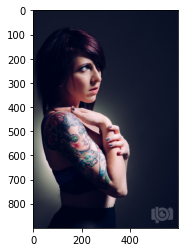

Caption= a of of a man
Answer= ['head and shoulders photo of a model with a colourful tattoo on her shoulder']
Img name: 10050
____________________
---------------------------------------------train model  2  on  sizedown-20k-dataset.pkl
image pickle is loaded
31158
len of encoding dict:  20589
image pickle (test) is loaded
11006 frequent words
modelid:  2
Model: "functional_77"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
captions (InputLayer)           [(None, 47)]         0                                            
__________________________________________________________________________________________________
image_features (InputLayer)     [(None, 2048)]       0                                            
__________________________________________________________________________________________________
glove_embedding (Embeddi

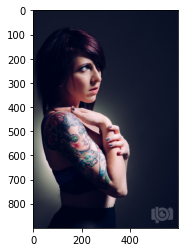

Caption= a of a of a background
Answer= ['head and shoulders photo of a model with a colourful tattoo on her shoulder']
Img name: 10050
____________________
---------------------------------------------train model  3  on  sizedown-20k-dataset.pkl
image pickle is loaded
31158
len of encoding dict:  20589
image pickle (test) is loaded
11006 frequent words
modelid:  3
Model: "functional_79"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
captions (InputLayer)           [(None, 49)]         0                                            
__________________________________________________________________________________________________
image_features (InputLayer)     [(None, 2048)]       0                                            
__________________________________________________________________________________________________
glove_embedding

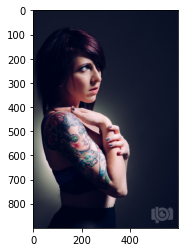

Caption= a man in a white background
Answer= ['head and shoulders photo of a model with a colourful tattoo on her shoulder']
Img name: 10050
____________________
---------------------------------------------train model  4  on  sizedown-20k-dataset.pkl
image pickle is loaded
31158
len of encoding dict:  20589
image pickle (test) is loaded
11006 frequent words
modelid:  4
Model: "functional_81"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
captions (InputLayer)           [(None, 51)]         0                                            
__________________________________________________________________________________________________
glove_embedding (Embedding)     (None, 51, 200)      2201800     captions[0][0]                   
__________________________________________________________________________________________________
image_feat

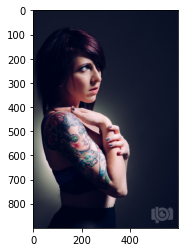

Caption= a of a of a of a
Answer= ['head and shoulders photo of a model with a colourful tattoo on her shoulder']
Img name: 10050
____________________


In [30]:
import pandas as pd

for ds in datasets:
    lookup,lex,max_length=loadmodel('/content/drive/Shareddrives/zhaozixuan67/20FallMLfinal/Project/Data/GCCmodels-dataset/'+ds)
    
    for MODELID in range(1,5):
        print("---------------------------------------------train model ",MODELID," on ",ds)
        #dont read
        img_path_list = glob.glob(f"{data_folder}/GCCdata_Dataset/GCCdata_Dataset/*.jpg")
        train_img_names = set(open(f'{data_folder}/GCCdata_text/GCC_8k.trainImages.txt').read().strip().split('\n'))
        test_img_names = set(open(f'{data_folder}/GCCdata_text/GCC_8k.testImages.txt').read().strip().split('\n'))

        #for windows
        # train_img_names = [img_path for img_path in img_path_list if img_path.split('\\')[-1] in train_img_names]
        # test_img_names = [img_path for img_path in img_path_list if img_path.split('\\')[-1] in test_img_names]
        
        #for Colab(Linux)
        train_img_names = [img_path for img_path in img_path_list if img_path.split('/')[-1] in train_img_names]
        test_img_names = [img_path for img_path in img_path_list if img_path.split('/')[-1] in test_img_names]

        #external_base_path = "./content/drive/Shared drives/AIGroup/BigDataProject"
        #gdrive_path = "./content/drive/My Drive/Homework_And_Projects/BigData"

        #working_base = external_base_path
        working_base= "/content/drive/Shareddrives/zhaozixuan67/20FallMLfinal/Project/workspace"

        if not os.path.exists("{}/GCC_img_encoded.pkl".format(working_base)):
            encoding_dict = {}
            for img_path in tqdm_notebook(train_img_names):
                img = load_img(img_path,target_size=(HEIGHT,WIDTH))
                id = os.path.basename(img_path).split('.')[0]
                encoding_dict[id] = encodeImage(img)
            with open("{}/GCC_img_encoded.pkl".format(working_base),'wb') as f:
                pickle.dump(encoding_dict,f)
            print("image pickle is saved.")
        else:
            with open("{}/GCC_img_encoded.pkl".format(working_base),'rb') as f:
                encoding_dict = pickle.load(f)
            print("image pickle is loaded")
        print(len(encoding_dict))
        oldencoding_dict=copy.copy(encoding_dict)
        encoding_dict={}

        for k,v in oldencoding_dict.items():
            if k in lookup.keys():
                encoding_dict[k]=v
        print("len of encoding dict: ",len(encoding_dict))

        if not os.path.exists("{}/GCC_img_encoded_test.pkl".format(working_base)):
            encoding_test_dict = {}
            for img_path in tqdm_notebook(test_img_names):
                img = load_img(img_path,target_size=(HEIGHT,WIDTH))
                id = os.path.basename(img_path).split('.')[0]
                encoding_test_dict[id] = encodeImage(img)
            with open("{}/GCC_img_encoded_test.pkl".format(working_base),'wb') as f:
                pickle.dump(encoding_test_dict,f)
            print("image pickle (test) is saved.")
        else:
            with open("{}/GCC_img_encoded_test.pkl".format(working_base),'rb') as f:
                encoding_test_dict = pickle.load(f)
            print("image pickle (test) is loaded")
        oldencoding_test_dict=copy.copy(encoding_test_dict)
        encoding_test_dict={}
        for k,v in oldencoding_test_dict.items():
            if k in lookup.keys():
                encoding_test_dict[k]=v
        len(encoding_test_dict)
        training_captions = []
        test_captions = []
        train_id_to_captions = {}
        test_id_to_captions = {}

        train_img_ids = [os.path.basename(img).split('.')[0] for img in train_img_names]
        test_img_ids = [os.path.basename(img).split('.')[0] for img in test_img_names]

        for id, caption_list in lookup.items():
            if id in train_img_ids:
                training_captions.extend(caption_list)
                train_id_to_captions[id] = caption_list
            elif id in test_img_ids:
                test_captions.extend(caption_list)
                test_id_to_captions[id] = caption_list

        len(training_captions),len(test_captions)
        randomindex=int(random.random()*(len(train_id_to_captions)-6))
        list(train_id_to_captions.values())[randomindex:randomindex+5]
        count_threshold = 0
        START,END = "startseq","endseq"
        word_counts = {}
        for id,cap in enumerate(training_captions): # for each sentence
            for w in cap.split(): # for each word
                word_counts[w] = word_counts.get(w,0) + 1
        freq_words = [w for w in word_counts if word_counts[w] >= count_threshold]
        print("{} frequent words".format(len(freq_words)))
        # add two indicators
        freq_words.extend([START,END])
        id_to_word,word_to_id = {},{}

        for id,w in enumerate(freq_words):
            word_to_id[w] = id+1
            id_to_word[id+1] = w

        vocab_size = len(word_to_id) + 1 # 
        vocab_size
        max_length += 2 # add "startseq","endseq"
        max_length
#         embedding_index = {}

#         with open(os.path.join(f'{base_folder}/glove.6B.200d.txt'),encoding='utf-8') as f:
#             for line in tqdm_notebook(f.readlines()):
#                 vals = line.split()
#                 word = vals[0]
#                 coefs = np.array(vals[1:],dtype='float32')
#                 embedding_index[word] = coefs

#         print(f"{len(embedding_index)} word vectors")
        embedding_dim = 200 # the vector length of the embedding

        embedding_matrix = np.zeros((vocab_size,embedding_dim))
        for word, index in word_to_id.items():
            embedding_vector = embedding_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[index] = embedding_vector
        embedding_matrix.shape
        caption_model=buildmodel(MODELID)
        print("modelid: ",MODELID)
        caption_model.summary()
        from tensorflow.keras.utils import plot_model
        print("modelid: ",MODELID)
        plot_model(caption_model,to_file="model"+str(MODELID)+"_struct.png",show_shapes=True,show_layer_names=True,dpi=70)
        if MODELID==4:
            embedding_layer = caption_model.layers[1]
        else:
            embedding_layer = caption_model.layers[2]
        #embedding_layer = caption_model.layers[2]
        embedding_layer.set_weights([embedding_matrix]) # should be a list, like the get_weights()
        embedding_layer.trainable = False
        caption_model.load_weights('/content/drive/Shareddrives/zhaozixuan67/20FallMLfinal/Project/workspace/ash/ash/ash-model{}-full--bat1024-ep100.h5'.format(MODELID))
        opt = optimizers.Adam(learning_rate=0.00001)
        caption_model.compile(loss='categorical_crossentropy', optimizer= opt)

        num_pics_per_batch = 512
        steps = len(training_captions) // num_pics_per_batch
        # model_path = "{}/caption_model.h5".format(working_base)
        model_path = working_base+"/chen/chen-model"+str(MODELID)+"-"+'1024'+"-ep"+str(epoches)+".h5"
        model_path
        print("steps: ",steps)

        gc.collect()

        train_model(caption_model,1024,model_path,MODELID,ds,EPOCHS=epoches)
        
        #test
        # caption_model.load_weights('/content/drive/Shareddrives/zhaozixuan67/20FallMLfinal/Project/workspace/chen/chen-model{}-sized-ep100.h5'.format(MODELID))
        # num= 1
        # if(MODELID == 1):
        #   image_names = np.random.choice(list(encoding_test_dict.keys()),num,False)
        # Captions = []
        # Answers = []
        # for i in range(num):
        #     image_name = '10050'
        #     image_encoding = encoding_test_dict[image_name].reshape((1,-1))
        #     full_image_path = f"{data_folder}/GCCdata_Dataset/GCCdata_Dataset/{image_name}.jpg"
        #     img = plt.imread(full_image_path)
        #     plt.imshow(img)
        #     plt.show()
        #     print("Caption=",generateCaption(image_encoding))
        #     print("Answer=",lookup[image_name])
        #     print("Img name:", image_name)
        #     print("_"*20)
        # #     full_image_path = f"/content/drive/Shareddrives/zhaozixuan67/20FallMLfinal/Project/Data/GCCdata_Dataset/GCCdata_Dataset/{image_name}.jpg"
        #     Captions.append(generateCaption(image_encoding))
        #     Answers.append(lookup[image_name])

        # df = pd.DataFrame({'names':image_names, 'gen':Captions, 'real':Answers})
        # df.to_csv('/content/drive/Shareddrives/zhaozixuan67/20FallMLfinal/Project/workspace/chen/ash1024_{}.csv'.format(MODELID),index=False)
